**Your Name**:  **Duncan**

<div style="background-color:#f2d7d5">

# Assignment 10: Merging DataFrames, Groupby Summaries, and Visualization
## Instructions:
- Work with your assigned group to submit a single document, although all group members will submit their own assignments on blackboard
- Due date: Friday May 5 by 7:00pm
- Your Jupyter notebook file (it has an `ipynb` extension) must be uploaded using Blackboard Assignments.
- Please start work ASAP as technical difficulties may arise requiring a little time to resolve.
- Post any problems you encounter on the course [issue tracker](https://code.wm.edu/econ/160/issues/-/issues).
- Celebrate that this is your last assignment!!


<div style="background-color:#f2d7d5">

## Rating students in your group

For each person in your group, please provide a rating of your fellow group members' contributions to this assignment.  The rating is on a five point scale, as follows:

- `1` : group member did much less than their share of the work
- `2` : group member did less than their share of the work
- `3` : group member did their share of the work 
- `4` : group member did more than their share of the work
- `5` : group member did much more than their share of the work.

For each member of your group (excluding yourself), enter your rating:

- Name: **Bruce**,    Rating: 3
- Name: **Cole**,    Rating: 3

<div style="background-color:#f2d7d5">

**General instructions for this assignment** 
- Use comments to annotate and explain the steps in your code.
- Some of the work on this assignment will require you to expand beyond what we've covered in class, so you might need to do some web searching.
- Do not under any circumstances reorder, reformat, or change the instruction cells (the ones in light red)

In the code cell below, we import all the python packages that we'll need for this notebook:

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
# Using seaborn styles really improves plotting in my opinion
# There are five preset seaborn themes: darkgrid, whitegrid, dark, white, and ticks
import seaborn as sbn
sbn.set_style(style='white')

# salaries (not mine, but in MLB) are large, so turn off scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

<div style="background-color:#f2d7d5">

This week we will be using some baseball data to examine the following questions:

1. How equitable are pitcher salaries across teams and leagues
2. Are pitcher salaries higher for pitchers with better pitching statistics?
3. How many pitchers are at or below the league minimum salary for 2021?
4. What type of pitchers tend to have higher salaries? Starters vs. Relievers? Left handed vs right handed?

To answer these questions, we will need four tables:

1. `salaries_playerid.xlsx`: Contains salary data for pitchers. The file has the following fields:
    - `name`: Last, First
    - `player_id`: official MLB player id.  This field is blank for fielders but exists for pitchers who had **any** appearances during 2021
    - `position`: for our purposes, we are only interested in `rhp-s` and `lhp-s` (right and left hand starting pitchers), and `rhp` and `lhp` (right and left hand relief pitchers)
    - `salary`: reported 2021 salary (if missing, the player was at the MLB minimimum salary $570,500 scaled by the fraction of the year they played)
2. `pitcher_performance_2021.xlsx`: contains several metrics for pitching performance based off of the all appearances in 2021
    - `player_name`: Last, First
    - `player_id`: official MLB player id
    - `velocity_mean`: mean fastball pitch velocity
    - `velocity_max`: maximum fastball pitch velocity
    - `velocity_std`: standard deviation of pitch velocity
    - `spin_mean`: mean curveball pitch spinrate
    - `spin_max`: maximum curveball pitch spinrate
    - `spin_std`: standard deviation of curveball pitch spinrate
    - `runs_scored`: average run scored against per inning
3. `player_team.xlsx`: Lists teams played for in 2021 for each player
    - `player_name`: Last, First
    - `player_id`: official MLB player id
    - `team` : MLB three letter team abbreviation
4. `team_abbreviations.xlsx`: For each team lists team name, three letter abbreviation, and league
    - `team_abbreviation`: MLB three letter team abbreviation
    - `team_name`: Official team name (e.g. New York Yankees)
    - `league`: the baseball league each team is in (either American or National)

For your convenience, I load these data below:

In [39]:
salaries_player_id = pd.read_excel('https://econ.pages.code.wm.edu/160/python/data/salaries_playerid.xlsx')
pitcher_performance = pd.read_excel('https://econ.pages.code.wm.edu/160/python/data/pitcher_performance_2021.xlsx')
player_team = pd.read_excel('https://econ.pages.code.wm.edu/160/python/data/player_team.xlsx')
team_abbreviations = pd.read_excel('https://econ.pages.code.wm.edu/160/python/data/team_abbreviations.xlsx')

<div style="background-color:#f2d7d5">

# Part A: Data Inventory, Cleanup, and Data Preparation

<div style="background-color:#f2d7d5">

Do whatever steps you think is necessary to

1. Clean data/column names

In [40]:
salaries_player_id.columns

Index(['name', 'player_id', 'position', 'salary'], dtype='object')

In [41]:
pitcher_performance.columns

Index(['player_name', 'player_id', 'velocity_mean', 'velocity_max',
       'velocity_std', 'spin_mean', 'spin_max', 'spin_std', 'runs_scored'],
      dtype='object')

In [42]:
player_team.columns

Index(['player_name', 'player_id', 'team'], dtype='object')

In [43]:
team_abbreviations.columns

Index(['team_abbreviation', 'team_name', 'league'], dtype='object')

In [44]:
# rename like columns to the same name

salaries_player_id = salaries_player_id.rename(columns = {'name' : 'player_name'})

player_team = player_team.rename(columns = {'team' : 'team_abbreviation'})

<div style="background-color:#f2d7d5">

2. Summarize salaries and pitcher statistics.

In [45]:
salaries_player_id[['salary']].describe()

,salary
count,483.00
mean,3387299.17
std,5865404.53
min,570500.00
25%,584050.00
50%,870000.00
75%,3187500.00
max,36000000.00


In [46]:
# summarize all data not including player_id
pitcher_performance_temp = pitcher_performance.drop('player_id', axis = 1)
pitcher_performance_temp.describe()

,velocity_mean,velocity_max,velocity_std,spin_mean,spin_max,spin_std,runs_scored
count,884.00,884.00,870.00,884.00,884.00,870.00,884.00
mean,93.30,95.76,1.09,2247.42,2554.89,100.20,0.65
std,2.54,2.79,0.38,157.22,305.55,33.18,0.84
min,74.45,83.30,0.07,1689.09,1904.00,2.12,0.00
25%,91.90,94.10,0.91,2141.43,2353.00,79.34,0.01
50%,93.39,95.95,1.08,2245.63,2490.50,96.09,0.17
75%,94.85,97.60,1.27,2352.58,2672.75,114.46,1.30
max,100.71,102.80,7.11,2863.92,3594.00,333.17,6.00


<div style="background-color:#f2d7d5">

3. Investigate missing data and duplicate records in each source by player and team and any other steps you feel is necessary to help you in the merges you will need to perform below

   - `salaries_player_id` <-> `player_team`
   - `player_team` <-> `team_abbreviations`
   - `salaries_player_id` <-> `pitcher_performance`

In [47]:
# Check for missing data
print(salaries_player_id.info())

print('NULL VALUES:',salaries_player_id.isna().sum())

# Check for duplicates
print('DUPLICATES:', salaries_player_id.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   player_name  698 non-null    object 
 1   player_id    611 non-null    float64
 2   position     698 non-null    object 
 3   salary       483 non-null    float64
dtypes: float64(2), object(2)
memory usage: 21.9+ KB
None
NULL VALUES: player_name      0
player_id       87
position         0
salary         215
dtype: int64
DUPLICATES: 0


In [48]:
# Check for missing data
print(player_team.info())
print('NULL VALUES:',player_team.isna().sum())

# Check for duplicates
print("DUPLICATES:", player_team.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   player_name        1260 non-null   object
 1   player_id          1260 non-null   int64 
 2   team_abbreviation  1260 non-null   object
dtypes: int64(1), object(2)
memory usage: 29.7+ KB
None
NULL VALUES: player_name          0
player_id            0
team_abbreviation    0
dtype: int64
DUPLICATES: 0


In [49]:
# Check for missing data
print(team_abbreviations.info())
print("NULL VALUES:",team_abbreviations.isna().sum())

# Check for duplicates
print("DUPLICATES:",team_abbreviations.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   team_abbreviation  30 non-null     object
 1   team_name          30 non-null     object
 2   league             30 non-null     object
dtypes: object(3)
memory usage: 848.0+ bytes
None
NULL VALUES: team_abbreviation    0
team_name            0
league               0
dtype: int64
DUPLICATES: 0


In [50]:
# Check for missing data
print(pitcher_performance.info())
print("NULL VALUES:",pitcher_performance.isna().sum())

# Check for duplicates
print("DUPLICATES:",pitcher_performance.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   player_name    884 non-null    object 
 1   player_id      884 non-null    int64  
 2   velocity_mean  884 non-null    float64
 3   velocity_max   884 non-null    float64
 4   velocity_std   870 non-null    float64
 5   spin_mean      884 non-null    float64
 6   spin_max       884 non-null    int64  
 7   spin_std       870 non-null    float64
 8   runs_scored    884 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 62.3+ KB
None
NULL VALUES: player_name       0
player_id         0
velocity_mean     0
velocity_max      0
velocity_std     14
spin_mean         0
spin_max          0
spin_std         14
runs_scored       0
dtype: int64
DUPLICATES: 0


<div style="background-color:#f2d7d5">

## Part B: Investigate Salary Fairness in the MLB

<div style="background-color:#f2d7d5">

Investigate cross-team salary equity by pitcher type.  Develop a pandas preview that has teams rows in the index and pitch type as columns representing total salary for a team and position.  Also include a column that is total pitcher salaries across all positions. Your report should use readable team and position names rather than abbreviations.

In [51]:
salaries_player_id.head()

,player_name,player_id,position,salary
0,"Cole, Gerrit",543037.00,rhp-s,36000000.00
1,"deGrom, Jacob",594798.00,rhp-s,36000000.00
2,"Strasburg, Stephen",544931.00,rhp-s,35000000.00
3,"Scherzer, Max",453286.00,rhp-s,34503480.00
4,"Verlander, Justin",NaN,rhp-s,33000000.00


In [52]:
pitcher_performance.head()

,player_name,player_id,velocity_mean,velocity_max,velocity_std,spin_mean,spin_max,spin_std,runs_scored
0,"Abad, Fernando",472551,91.82,95.70,7.11,2147.79,2380,227.42,0.00
1,"Abbott, Cory",676265,92.61,94.60,0.92,2320.44,2685,99.66,1.43
2,"Abreu, Albert",656061,97.80,99.70,1.03,2132.29,2403,102.21,0.13
3,"Abreu, Bryan",650556,95.60,99.80,1.38,2212.50,2473,122.04,0.18
4,"Acevedo, Domingo",642758,92.90,95.40,1.08,2071.90,2349,106.30,0.00


In [53]:
player_team.head()

,player_name,player_id,team_abbreviation
0,"Smith, Will",519293,ATL
1,"Matzek, Tyler",554431,ATL
2,"Fried, Max",608331,ATL
3,"Graveman, Kendall",608665,HOU
4,"Stanek, Ryne",592773,HOU


In [54]:
team_abbreviations.head()

,team_abbreviation,team_name,league
0,HOU,Houston Astros,American
1,ATL,Atlanta Braves,National
2,LAD,Los Angelas Dodgers,National
3,BOS,Boston Red Sox,American
4,SF,San Francisco Giants,National


In [55]:
#perform merges on playerid
spp = salaries_player_id.merge(pitcher_performance, on='player_id', how = 'left')

In [56]:
sppta = spp.merge(player_team, on = 'player_id', how = 'left')

<div style="background-color:#f2d7d5">

Once you are happy with your merge result commit it to a dataframe called `player_salaries` for further analysis:

In [57]:
data = sppta.merge(team_abbreviations, on = 'team_abbreviation', how = 'left')

In [58]:
player_salaries = data.groupby(['team_name','position'])[['salary']].agg(['sum']).unstack()

In [59]:
player_salaries['Total Salary'] = player_salaries.iloc[0:30].sum(axis=1)

<div style="background-color:#f2d7d5">

Now develop your preview of player salary totals by pitcher and team. Also include a total salaries for each team (totaled across all pitcher positions):

In [60]:
player_salaries.columns

MultiIndex([(      'salary', 'sum',   'lhp'),
            (      'salary', 'sum', 'lhp-s'),
            (      'salary', 'sum',   'rhp'),
            (      'salary', 'sum', 'rhp-s'),
            ('Total Salary',    '',      '')],
           names=[None, None, 'position'])

In [61]:
# rename positions to more readable terms
player_salaries.set_axis(['Reliever (L)', 'Starter (L)', 'Reliever (R)', 'Starter (R)', 'Total Salary'], axis=1, inplace = True)

<ipython-input-61-37bd69e646e5>:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  player_salaries.set_axis(['Reliever (L)', 'Starter (L)', 'Reliever (R)', 'Starter (R)', 'Total Salary'], axis=1, inplace = True)


In [62]:
#preview
player_salaries

,Reliever (L),Starter (L),Reliever (R),Starter (R),Total Salary
team_name,,,,,
Atlanta Braves,15800500.00,15100500.00,14846500.00,17800000.00,63547500.00
Baltimore Orioles,1861000.00,593500.00,5422200.00,1586750.00,9463450.00
Boston Red Sox,1747000.00,36973150.00,24246000.00,26113500.00,89079650.00
Chicago Cubs,3100000.00,NaN,5497000.00,29703000.00,38300000.00
Chicago White Sox,3434500.00,21000000.00,17048833.00,13483333.00,54966666.00
Cincinnati Reds,4922500.00,8000000.00,9950000.00,22863167.00,45735667.00
Cleveland Guardians,1821500.00,603000.00,8039400.00,1266100.00,11730000.00
Colorado Rockies,1146000.00,5025000.00,15532000.00,18700000.00,40403000.00
Detroit Tigers,6132700.00,NaN,3971600.00,10511000.00,20615300.00


<div style="background-color:#f2d7d5">

Using your result above, plot a horizontal bar chart by team for total pitcher salaries by team with bars oriented on the y axis from smallest (closest to the origin) to lowest (furthest from the origin).  For figure aesthetics,
- remove the axis spines
- remove the y axis label (`team_name`)
- label the salary axis
- add a title to the plot  

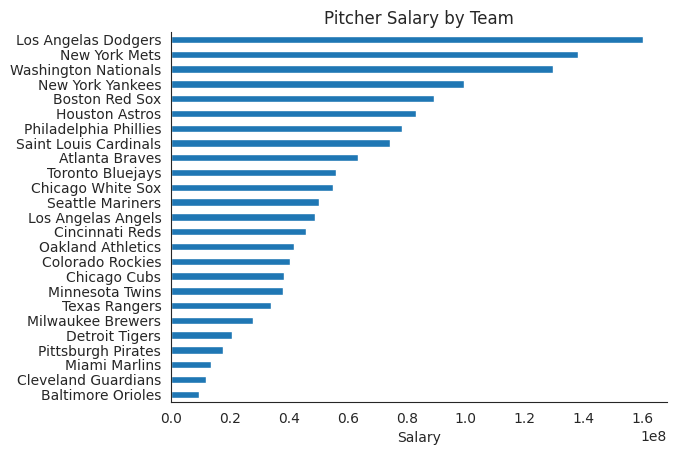

In [63]:
fig, ax = plt.subplots(1,1)

player_salaries.groupby(['team_name'])['Total Salary'].mean().sort_values().plot(kind='barh');

#plot and axis titles
ax.set_title('Pitcher Salary by Team')
ax.set_xlabel('Salary')
ax.set_ylabel('')

#remove axis spines
sbn.despine()

#show plot
plt.show()

<div style="background-color:#f2d7d5">

Plot another horizontal bar chart having two stacked axes: one for the American League teams (on top) and one for the National League (on bottom).  The horizontal bar chart should show grouped bar charts on expenditures for each of the positions by team.  For figure aesthetics,
- remove the axis spines
- remove the legend for one of your axes (since they should be the same)
- remove the y axis label (`team_name`)
- label the salary axis

Your figure should look close to this (note I am using a log scale):

![image.png](attachment:image.png)

Comment on the things in the chart that are most striking.

In [64]:
#merge master dataset to player_salaries to get league data
info = player_salaries.merge(data, how = 'left', on = 'team_name')

#groupby team, league on positions
info_ = info.groupby(['league', 'team_name'])[['Reliever (L)', 'Starter (L)', 'Reliever (R)', 'Starter (R)']].mean()

In [65]:
info_.unstack().head(2)

Reliever (L)                                                \
team_name Atlanta Braves Baltimore Orioles Boston Red Sox Chicago Cubs   
league                                                                   
American             NaN        1861000.00     1747000.00          NaN   
National     15800500.00               NaN            NaN   3100000.00   

                                                                 \
team_name Chicago White Sox Cincinnati Reds Cleveland Guardians   
league                                                            
American         3434500.00             NaN          1821500.00   
National                NaN      4922500.00                 NaN   

                                                          ...   Starter (R)  \
team_name Colorado Rockies Detroit Tigers Houston Astros  ... New York Mets   
league                                                    ...                 
American               NaN     6132700.00     3236400.00  ...           NaN   
National        1146000.00            NaN            NaN  ...   92325000.00   

                                                                    \
team_name New York Yankees Oakland Athletics Philadelphia Phillies   
league                                                               
American       61999775.00               NaN                   NaN   
National               NaN               NaN           53716667.00   

                                                                     \
team_name Pittsburgh Pirates Saint Louis Cardinals Seattle Mariners   
league                                                                
American                 NaN                   NaN       2950000.00   
National          4730000.00           42675800.00              NaN   

                                                               
team_name Texas Rangers Toronto Bluejays Washington Nationals  
league                                                         
American    15266667.00      12592900.00                  NaN  
National            NaN              NaN          71003480.00  

[2 rows x 100 columns]

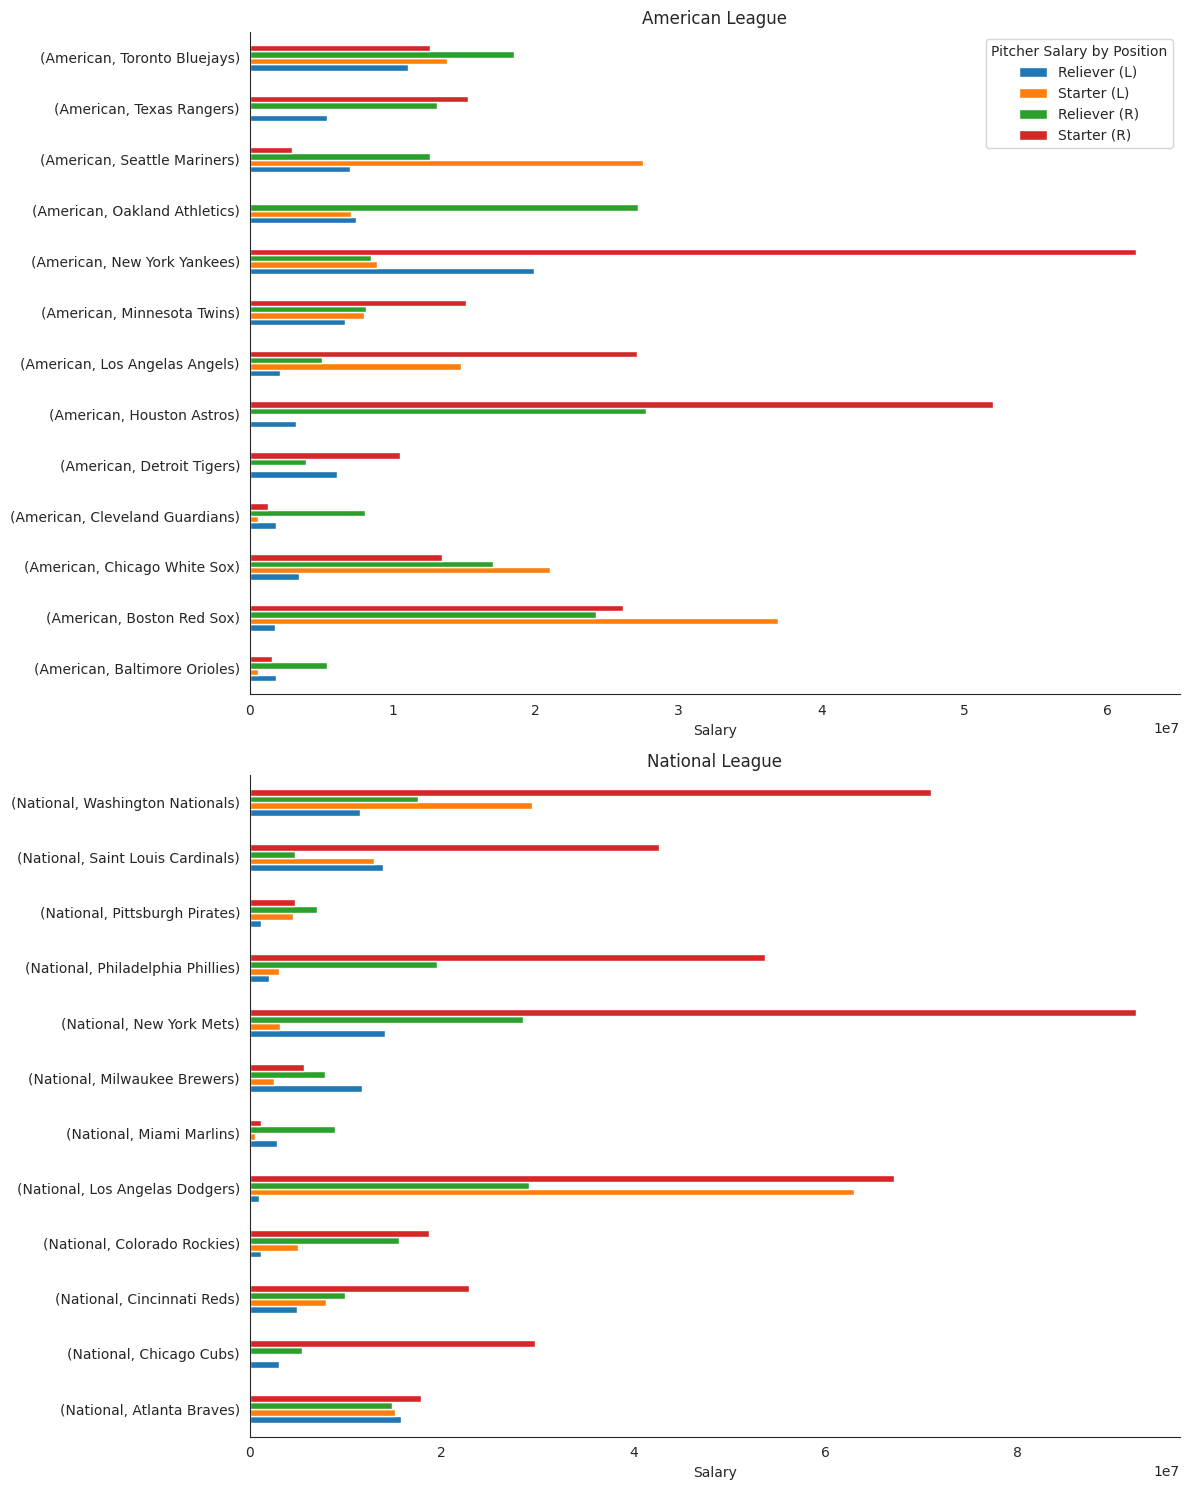

In [66]:
#create two axes, one for each league
fig, (ax_al, ax_nl) = plt.subplots(2,1, figsize=(12,15))

#AL
info_.query('league == "American"').plot(kind = 'barh', ax = ax_al)

#NL
info_.query('league == "National"').plot(kind = 'barh', ax = ax_nl)

#AL figure aesthetics
ax_al.legend(title = 'Pitcher Salary by Position')
ax_al.set_title('American League')
ax_al.set_xlabel('Salary')
ax_al.set_ylabel('')

#NL figure aesthetics
ax_nl.legend().remove()
ax_nl.set_title('National League')
ax_nl.set_xlabel('Salary')
ax_nl.set_ylabel('')

#clean up
sbn.despine()
plt.tight_layout()

#show plot
plt.show()

**Comments:**
It looks like right handed starting pitchers are paid the most, and earn more on average in the NL. It also seems that the highest paid players tend to go to the big market teams (NYY, NYM, LA, etc.), which makes sense as they have the most money to attract the best players. Another observation is that left handed relievers tend to get the least amount of money across the entire MLB.

<div style="background-color:#f2d7d5">

## Part C

<div style="background-color:#f2d7d5">

Next let's visually investigate the relationship between salaries and pitcher statistics.  We will plot 3 scatterplots for each pair of pitcher characteristics: runs scored per inning, mean spin rates, and mean velocity.  Further, you will scale each point by the player's salary (note since salaries are so large, you may need to divide salaries by 1 million when setting point sizes for the plot to look ok).  Here is an example plot for one of the pairs (velocity and spinrates):

![image.png](attachment:image.png)


You will first need to merge the salary (`salaries_player_id`) and performance data (`pitcher_performance`) you may also need to remove players having no salary data:

In [67]:
player_stats = salaries_player_id.merge(pitcher_performance, on = 'player_id', how = 'left')

#drop players with no salary data
player_stats = player_stats.dropna(subset = ['salary'])

<div style="background-color:#f2d7d5">

With the merge completed, plot the pairs of pitching characteristics taking care to scale the point size by salary.

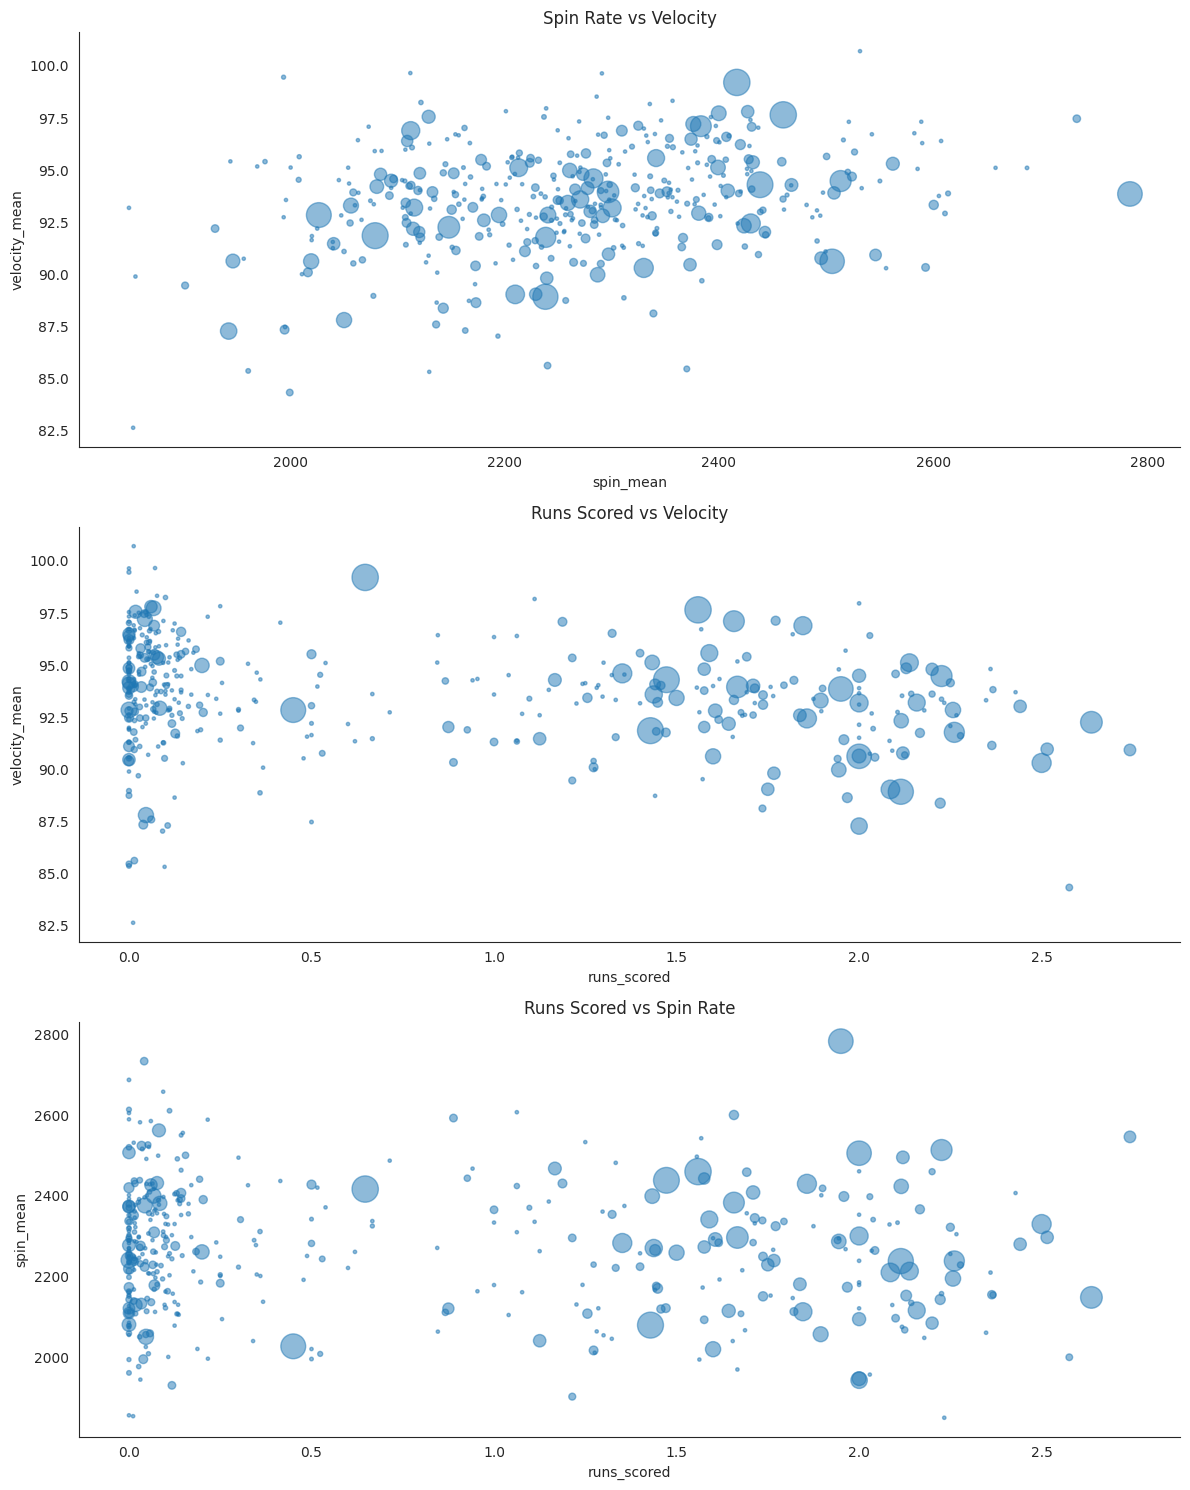

In [68]:
#create 3 plots
fig, (ax, ax1, ax2) = plt.subplots(3,1, figsize=(12,15))

#spin rate vs velocity
player_stats.plot(kind = 'scatter', x = 'spin_mean', y = 'velocity_mean', s = player_stats['salary']/100000, alpha = .5, ax=ax)

#velocity vs runs scored
player_stats.plot(kind = 'scatter', x = 'runs_scored', y = 'velocity_mean', s = player_stats['salary']/100000, alpha = .5, ax=ax1)

#spin rate runs scored
player_stats.plot(kind = 'scatter', x = 'runs_scored', y = 'spin_mean', s = player_stats['salary']/100000, alpha = .5, ax=ax2)

#titles
ax.set_title('Spin Rate vs Velocity')
ax1.set_title('Runs Scored vs Velocity')
ax2.set_title('Runs Scored vs Spin Rate')

#clean up
plt.tight_layout()
sbn.despine()

#show plot
plt.show()

<div style="background-color:#f2d7d5">

Discuss the following based on your visualizations:

1. Are pitcher characteristics like velocity, spinrates, and runs scored against obviously correlated (you don't need to compute anything, just discuss what you see)?
2. Is there a clear correspondence between these characteristics and salary?

There seems to be somewhat of a correlation between velocity and spin rate. However, there doesn't seem to be a clear correspondence bewteen these any of the characteristics and salary.

<div style="background-color:#f2d7d5">

## Part D. Salaries by Position and Minimum Salaries

<div style="background-color:#f2d7d5">

Find the number of players at or below the minimum salary for 2021. Players having missing values for salary are also at or below the minimum.

In [69]:
data['salary'].min()

570500.0

In [70]:
data['salary'].isna().value_counts()

False    552
True     246
Name: salary, dtype: int64

In [71]:
len(data.query("salary == 570500"))

19

In [72]:
print('Number of players at or below the minimum salary for 2021 is:', 19 + 246)

Number of players at or below the minimum salary for 2021 is: 265


<div style="background-color:#f2d7d5">

Now create a summary table describing the average and maximum salary by position and league (try to use nice labels with position):

In [73]:
data.head(2)

,player_name_x,player_id,position,salary,player_name_y,velocity_mean,velocity_max,velocity_std,spin_mean,spin_max,spin_std,runs_scored,player_name,team_abbreviation,team_name,league
0,"Cole, Gerrit",543037.00,rhp-s,36000000.00,"Cole, Gerrit",97.65,101.50,1.18,2460.02,3100.00,127.31,1.56,"Cole, Gerrit",NYY,New York Yankees,American
1,"deGrom, Jacob",594798.00,rhp-s,36000000.00,"deGrom, Jacob",99.21,102.00,1.10,2416.67,3581.00,102.76,0.65,"deGrom, Jacob",NYM,New York Mets,National


In [74]:
sal = data.groupby(['position', 'league'])['salary'].agg(['mean', 'max']).unstack()

sal = sal.rename(index={
    'lhp': 'Reliever (L)',
    'lhp-s': 'Starter (L)',
    'rhp': 'Reliever (R)',
    'rhp-s': 'Starter (R)'
})

sal

mean                    max            
league         American   National    American    National
position                                                  
Reliever (L) 1769157.95 2682658.06 13000000.00 13000000.00
Starter (L)  6628254.76 8181931.50 24173150.00 32000000.00
Reliever (R) 1521818.71 1740710.48 11333333.00 11666667.00
Starter (R)  5581367.77 7917240.52 36000000.00 36000000.00

<div style="background-color:#f2d7d5">

Discuss clear patterns across positions and leagues with respect to pitcher salaries.

The mean salary is higher for pitchers in the National League than in the American league. For Reliever (L) and Starter (R) the max salary is the same in both leagues, but for the other two positions, the National League has higher max salaries. Starters also get paid a lot more than relievers overall.